# 🌬️ Wind Onshore - Data Exploration

**Ziel:** Verstehen der Wind Onshore Zeitreihe

**Energy Type:** Wind Onshore (Land-basierte Windkraft)

**Erwartungen:**
- Höhere Volatilität als Wind Offshore (weniger konstante Winde)
- Potentiell mehr Nullwerte (Flauten)
- Wetterabhängig ohne Meereskonstante
- CV vermutlich 0.4-0.7

**Vergleich:**
- Solar: Starke tägliche Muster, CV=0.45
- Wind Offshore: 9-Monats-Outage, CV=0.26 (after cleaning)

**Fokus:** Data Quality Check & Pattern Discovery

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (16, 6)

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [6]:
# Load raw data
data_path = Path('../../data/raw/wind_onshore_2022-01-01_2024-12-31_hour.csv')

df_raw = pd.read_csv(data_path, parse_dates=['timestamp'])
df_raw.sort_values('timestamp', inplace=True)
df_raw.reset_index(drop=True, inplace=True)

print(f"Dataset: {len(df_raw):,} rows")
print(f"Period: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")
print(f"Duration: {(df_raw['timestamp'].max() - df_raw['timestamp'].min()).days} days")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst rows:")
df_raw.head()

Dataset: 26,257 rows
Period: 2022-01-02 23:00:00 to 2024-12-31 23:00:00
Duration: 1094 days

Columns: ['timestamp', 'value']

First rows:


,timestamp,value
0,2022-01-02 23:00:00,6254.00
1,2022-01-03 00:00:00,6047.75
2,2022-01-03 01:00:00,5705.00
3,2022-01-03 02:00:00,5713.50
4,2022-01-03 03:00:00,5781.00


In [7]:
# Basic statistics
print("Basic Statistics:")
print(df_raw['value'].describe())
print(f"\nMissing values: {df_raw['value'].isna().sum()} ({df_raw['value'].isna().sum()/len(df_raw)*100:.2f}%)")
print(f"Zero values: {(df_raw['value'] == 0).sum()} ({(df_raw['value'] == 0).sum()/len(df_raw)*100:.2f}%)")

Basic Statistics:
count    26257.000000
mean      2805.252257
std       1867.520683
min          0.000000
25%       1117.750000
50%       2615.500000
75%       4408.500000
max       7633.250000
Name: value, dtype: float64

Missing values: 0 (0.00%)
Zero values: 21 (0.08%)


## 2. Timeline Analysis (Outage Detection)

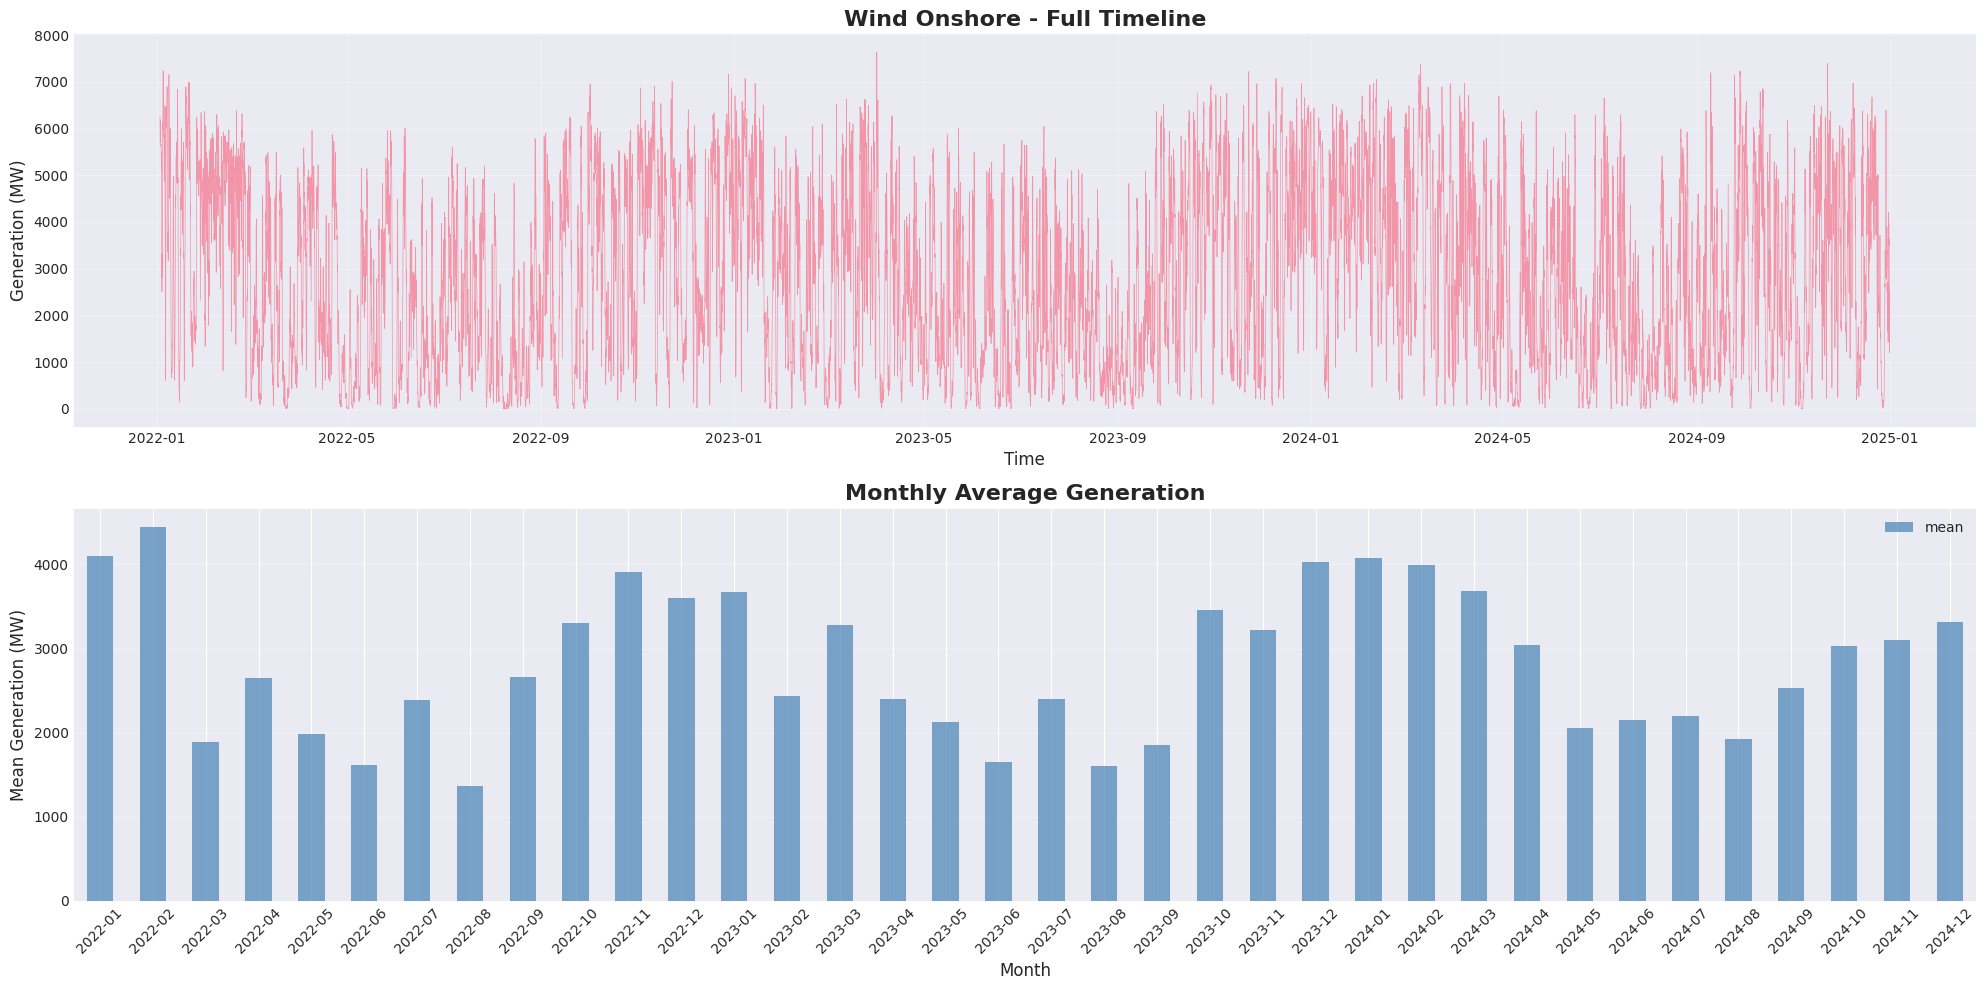


Monthly Statistics:
                   mean          std     min      max  count  zeros_pct
year_month                                                             
2022-01     4101.971306  1865.479374  147.50  7229.25    697   0.000000
2022-02     4442.077009  1193.816909  238.25  6383.75    672   0.000000
2022-03     1891.236559  1483.231023    4.75  5499.50    744   0.000000
2022-04     2650.992708  1663.707831   47.25  5961.50    720   0.000000
2022-05     1989.668011  1700.202593    0.00  5959.00    744   0.537634
2022-06     1620.437153  1366.682083   11.75  6004.25    720   0.000000
2022-07     2388.468750  1370.002076   37.00  5600.50    744   0.000000
2022-08     1364.530578  1271.961165    0.00  5786.75    744   0.806452
2022-09     2661.400000  1924.931971    4.25  6353.25    720   0.000000
2022-10     3308.879704  1743.452021  164.75  6954.75    744   0.000000
2022-11     3909.363542  1796.047521   18.75  7008.75    720   0.000000
2022-12     3600.398522  1729.025890   22.7

In [8]:
# Timeline visualization
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Full timeline
axes[0].plot(df_raw['timestamp'], df_raw['value'], linewidth=0.5, alpha=0.7)
axes[0].set_title('Wind Onshore - Full Timeline', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Monthly aggregation to spot outages
df_raw['year_month'] = df_raw['timestamp'].dt.to_period('M')
monthly_stats = df_raw.groupby('year_month')['value'].agg(['mean', 'std', 'min', 'max', 'count'])
monthly_stats['zeros_pct'] = df_raw.groupby('year_month')['value'].apply(lambda x: (x == 0).sum() / len(x) * 100)

monthly_stats.plot(y='mean', ax=axes[1], kind='bar', color='steelblue', alpha=0.7)
axes[1].set_title('Monthly Average Generation', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Mean Generation (MW)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nMonthly Statistics:")
print(monthly_stats)

In [9]:
# Check for problematic months (>90% zeros or very low generation)
problematic_months = monthly_stats[
    (monthly_stats['zeros_pct'] > 90) | 
    (monthly_stats['mean'] < monthly_stats['mean'].quantile(0.05))
]

if len(problematic_months) > 0:
    print("⚠️ PROBLEMATIC MONTHS DETECTED:")
    print(problematic_months)
    print(f"\n🚨 Action required: {len(problematic_months)} months may need removal")
else:
    print("✅ No major outages detected")
    print("Data appears clean - no extended periods of zeros")

⚠️ PROBLEMATIC MONTHS DETECTED:
                   mean          std   min      max  count  zeros_pct
year_month                                                           
2022-08     1364.530578  1271.961165  0.00  5786.75    744   0.806452
2023-08     1606.644489  1154.569024  5.25  5117.50    744   0.000000

🚨 Action required: 2 months may need removal


## 3. Data Quality Check

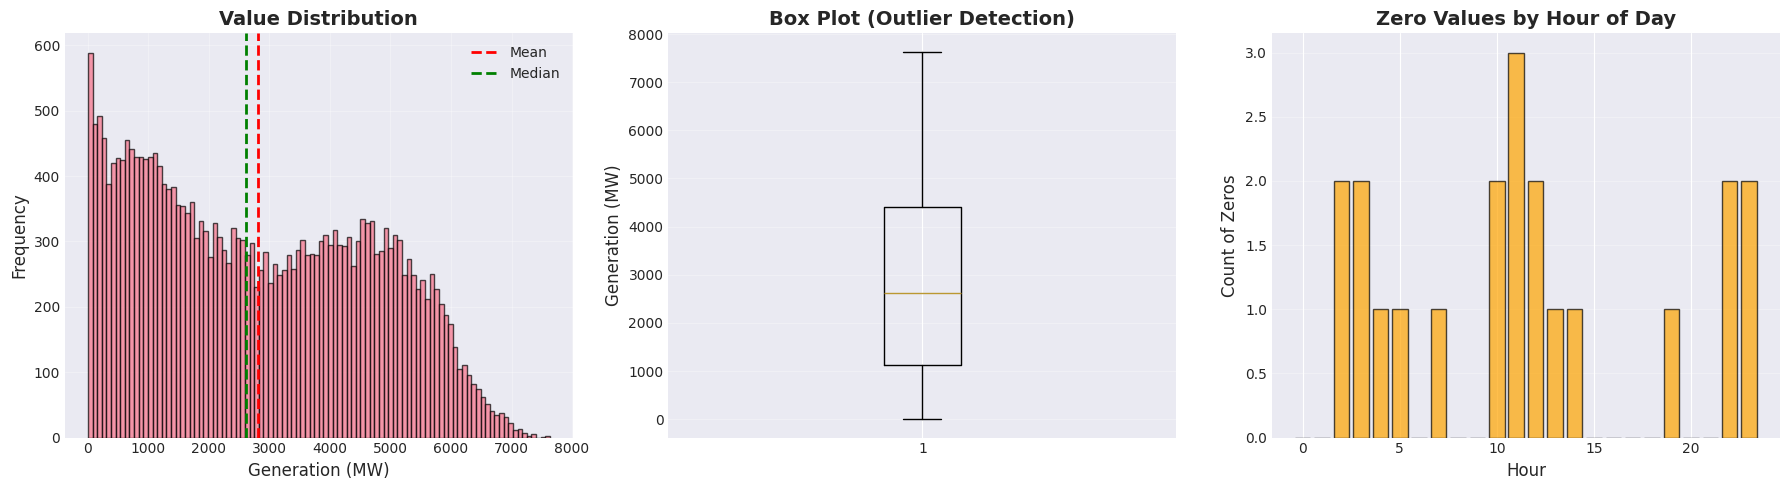


📊 Distribution Insights:
Skewness: 0.237
Kurtosis: -1.149
Coefficient of Variation: 0.666


In [10]:
# Distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_raw['value'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Value Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Generation (MW)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df_raw['value'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_raw['value'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_raw['value'], vert=True)
axes[1].set_title('Box Plot (Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Generation (MW)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Zeros analysis
zero_counts = (df_raw['value'] == 0).astype(int)
zero_by_hour = df_raw.groupby(df_raw['timestamp'].dt.hour)['value'].apply(lambda x: (x == 0).sum())
axes[2].bar(zero_by_hour.index, zero_by_hour.values, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Zero Values by Hour of Day', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hour', fontsize=12)
axes[2].set_ylabel('Count of Zeros', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Distribution Insights:")
print(f"Skewness: {df_raw['value'].skew():.3f}")
print(f"Kurtosis: {df_raw['value'].kurtosis():.3f}")
print(f"Coefficient of Variation: {df_raw['value'].std() / df_raw['value'].mean():.3f}")

## 4. Statistical Properties

In [11]:
# Summary statistics
stats_dict = {
    'Mean': df_raw['value'].mean(),
    'Median': df_raw['value'].median(),
    'Std': df_raw['value'].std(),
    'Min': df_raw['value'].min(),
    'Max': df_raw['value'].max(),
    'Q1': df_raw['value'].quantile(0.25),
    'Q3': df_raw['value'].quantile(0.75),
    'IQR': df_raw['value'].quantile(0.75) - df_raw['value'].quantile(0.25),
    'CV': df_raw['value'].std() / df_raw['value'].mean(),
    'Zeros %': (df_raw['value'] == 0).sum() / len(df_raw) * 100
}

stats_df = pd.DataFrame(stats_dict, index=['Wind Onshore']).T
print("\n📈 Statistical Summary:")
print(stats_df.to_string())

print("\n💡 Comparison Benchmarks:")
print(f"   Solar CV: 0.45 (moderate)")
print(f"   Wind Offshore CV: 0.26 (low - post cleaning)")
print(f"   Wind Onshore CV: {stats_dict['CV']:.3f} {'(HIGH - more volatile!)' if stats_dict['CV'] > 0.5 else '(moderate)'}")


📈 Statistical Summary:
         Wind Onshore
Mean      2805.252257
Median    2615.500000
Std       1867.520683
Min          0.000000
Max       7633.250000
Q1        1117.750000
Q3        4408.500000
IQR       3290.750000
CV           0.665723
Zeros %      0.079979

💡 Comparison Benchmarks:
   Solar CV: 0.45 (moderate)
   Wind Offshore CV: 0.26 (low - post cleaning)
   Wind Onshore CV: 0.666 (HIGH - more volatile!)


## 5. Temporal Patterns

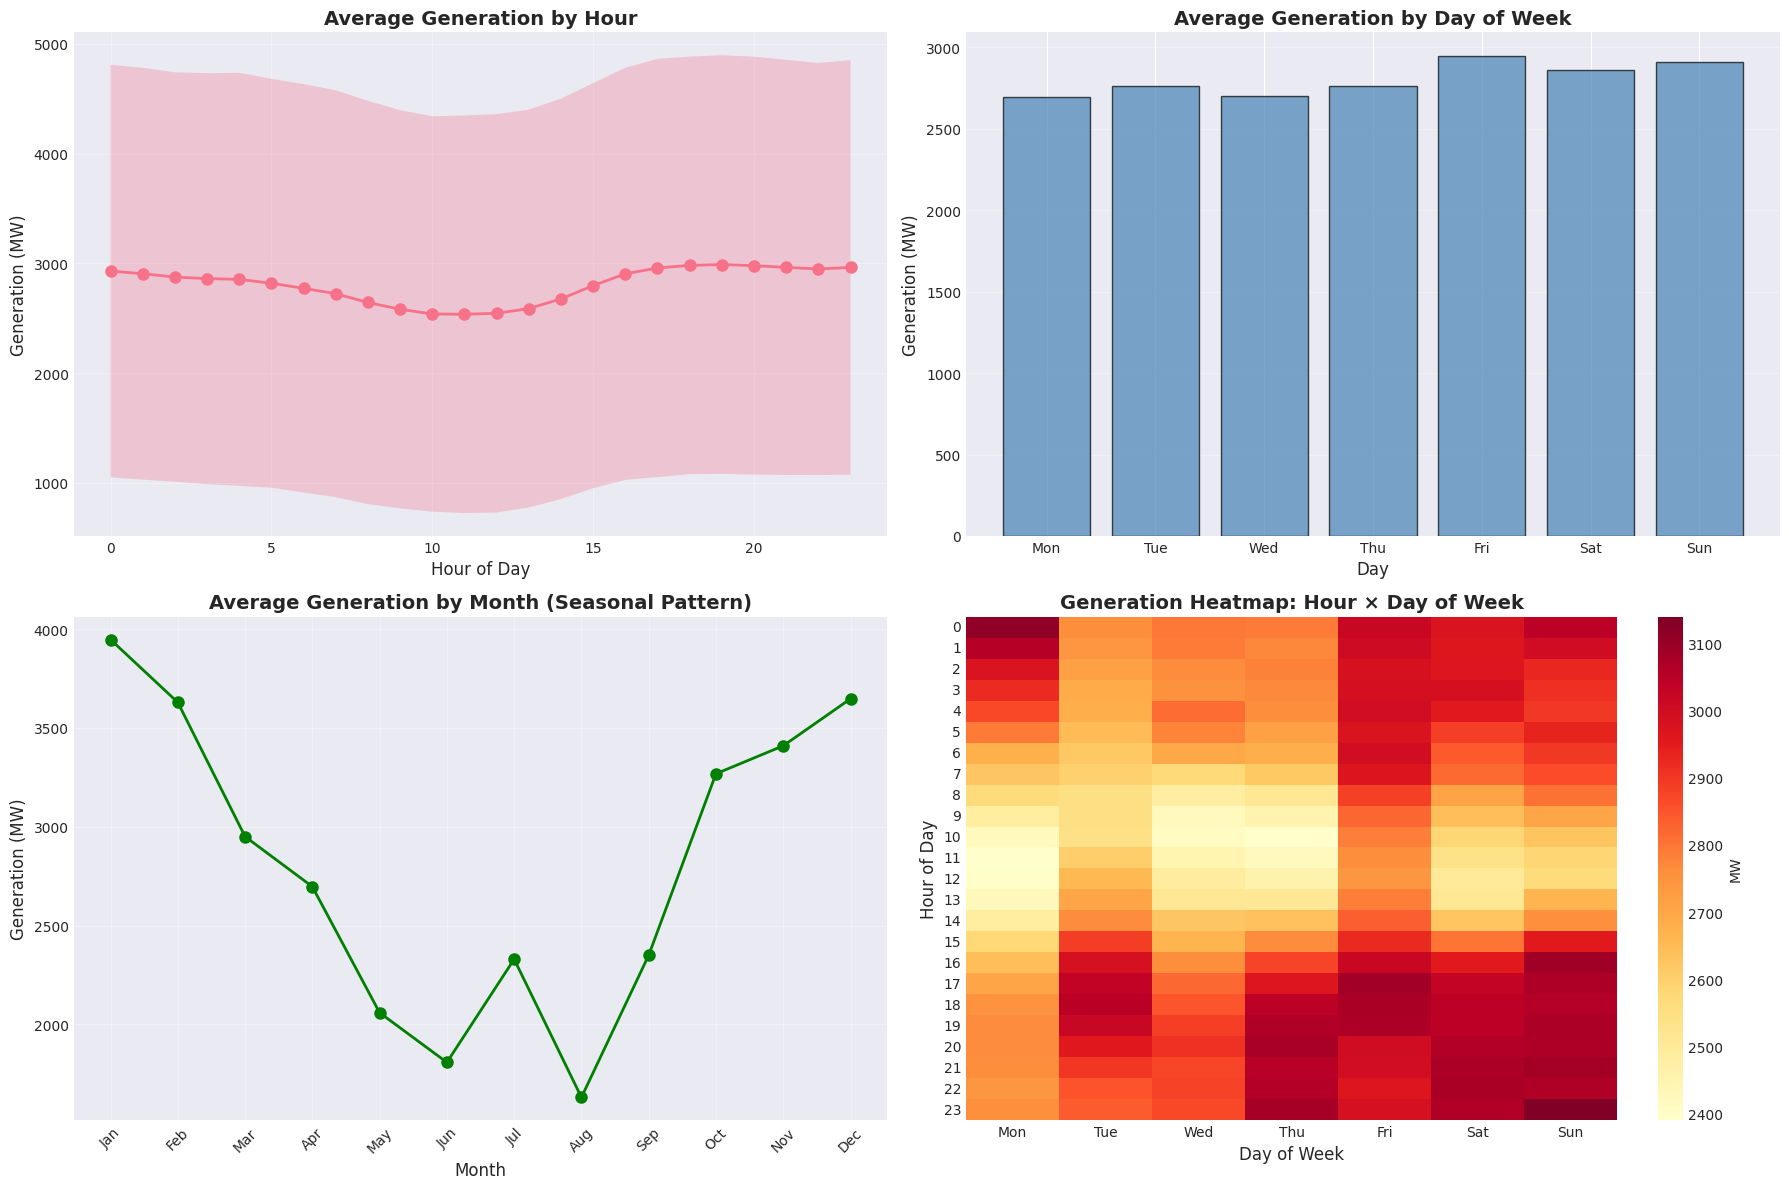


🔍 Pattern Insights:
Hourly variation: 160.68 MW
Daily variation: 99.66 MW
Monthly variation: 778.49 MW

💡 Wind patterns are highly variable


In [12]:
# Extract time features
df_raw['hour'] = df_raw['timestamp'].dt.hour
df_raw['dayofweek'] = df_raw['timestamp'].dt.dayofweek
df_raw['month'] = df_raw['timestamp'].dt.month

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Hourly pattern
hourly_mean = df_raw.groupby('hour')['value'].mean()
hourly_std = df_raw.groupby('hour')['value'].std()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].fill_between(hourly_mean.index, 
                         hourly_mean - hourly_std, 
                         hourly_mean + hourly_std, 
                         alpha=0.3)
axes[0, 0].set_title('Average Generation by Hour', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Generation (MW)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Day of week pattern
dow_mean = df_raw.groupby('dayofweek')['value'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_mean.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].set_title('Average Generation by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Day', fontsize=12)
axes[0, 1].set_ylabel('Generation (MW)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern
monthly_mean = df_raw.groupby('month')['value'].mean()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_labels, rotation=45)
axes[1, 0].set_title('Average Generation by Month (Seasonal Pattern)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Generation (MW)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Heatmap: Hour × Day of Week
heatmap_data = df_raw.pivot_table(values='value', index='hour', columns='dayofweek', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'MW'})
axes[1, 1].set_title('Generation Heatmap: Hour × Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week', fontsize=12)
axes[1, 1].set_ylabel('Hour of Day', fontsize=12)
axes[1, 1].set_xticklabels(dow_labels)

plt.tight_layout()
plt.show()

print("\n🔍 Pattern Insights:")
print(f"Hourly variation: {hourly_mean.std():.2f} MW")
print(f"Daily variation: {dow_mean.std():.2f} MW")
print(f"Monthly variation: {monthly_mean.std():.2f} MW")
print(f"\n💡 Wind patterns are {'weather-driven' if hourly_mean.std() < 100 else 'highly variable'}")

## 6. Optimal Test Period Selection

In [13]:
# Analyze potential test periods (full months)
df_raw['year'] = df_raw['timestamp'].dt.year
test_candidates = df_raw.groupby(['year', 'month'])['value'].agg([
    'count', 'mean', 'std', 'min', 'max',
    ('zeros_pct', lambda x: (x == 0).sum() / len(x) * 100)
])

# Filter: At least 600 samples, low zeros, high generation
good_periods = test_candidates[
    (test_candidates['count'] >= 600) &
    (test_candidates['zeros_pct'] < 5) &
    (test_candidates['mean'] > test_candidates['mean'].quantile(0.6))
].sort_values('mean', ascending=False)

print("\n🎯 Top 5 Test Period Candidates:")
print(good_periods.head(10))

if len(good_periods) > 0:
    best_period = good_periods.index[0]
    print(f"\n✅ RECOMMENDED TEST PERIOD: {best_period[0]}-{best_period[1]:02d}")
    print(f"   Mean generation: {good_periods.iloc[0]['mean']:.2f} MW")
    print(f"   Zero values: {good_periods.iloc[0]['zeros_pct']:.2f}%")
    print(f"   Samples: {good_periods.iloc[0]['count']}")
else:
    print("⚠️ No ideal test period found - may need to relax criteria")


🎯 Top 5 Test Period Candidates:
            count         mean          std     min      max  zeros_pct
year month                                                             
2022 2        672  4442.077009  1193.816909  238.25  6383.75   0.000000
     1        697  4101.971306  1865.479374  147.50  7229.25   0.000000
2024 1        744  4078.587702  1513.042781  226.75  6522.50   0.000000
2023 12       744  4025.832997  1858.483848   80.00  7075.25   0.000000
2024 2        696  3997.426006  1722.521028  205.50  7050.75   0.000000
2022 11       720  3909.363542  1796.047521   18.75  7008.75   0.000000
2024 3        744  3678.417003  2029.333888   67.25  7367.50   0.000000
2023 1        744  3670.261761  1838.582693    0.00  7072.25   0.134409
2022 12       744  3600.398522  1729.025890   22.75  7162.25   0.000000
2023 10       744  3463.217070  1775.580823   95.75  6936.00   0.000000

✅ RECOMMENDED TEST PERIOD: 2022-02
   Mean generation: 4442.08 MW
   Zero values: 0.00%
   Samples: 67

## 7. Autocorrelation Analysis

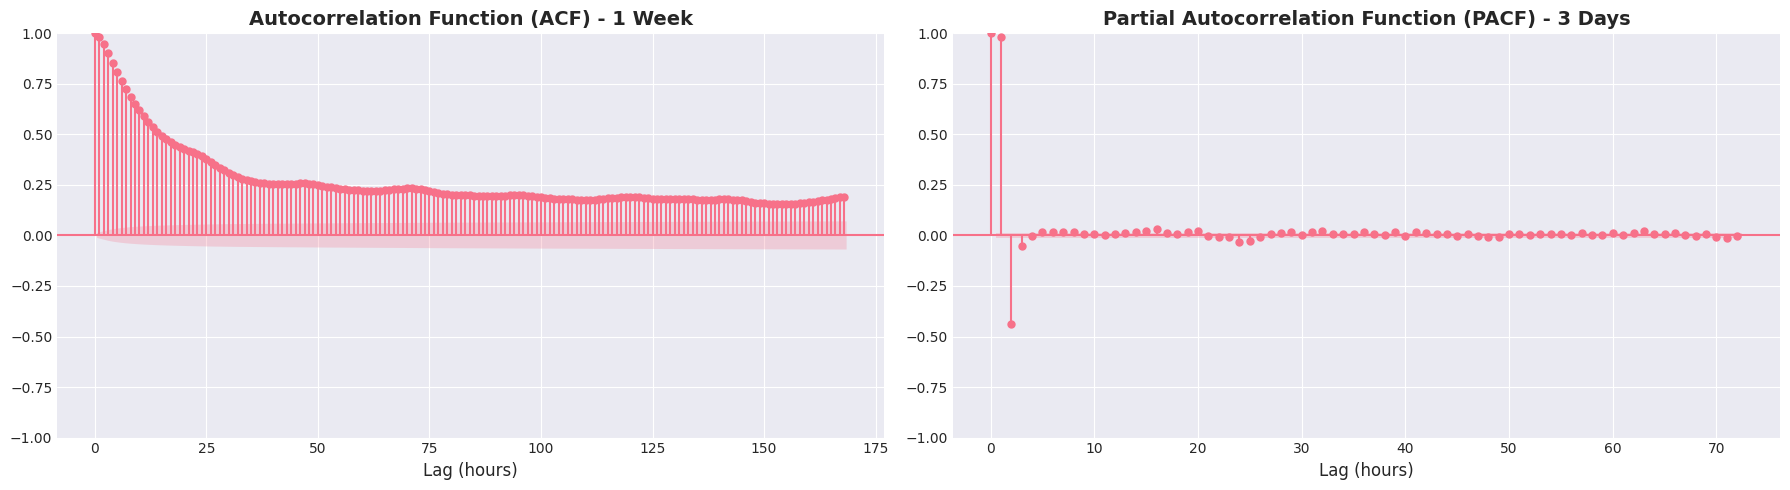


📊 Autocorrelation Insights:
Strong correlations at lag 1, 2, 3 expected for wind
Daily patterns (lag 24) may be weak compared to solar
Weekly patterns (lag 168) typically minimal for wind


In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Remove zeros for cleaner ACF
df_clean = df_raw[df_raw['value'] > 0].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# ACF
plot_acf(df_clean['value'].values, lags=168, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - 1 Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (hours)', fontsize=12)

# PACF
plot_pacf(df_clean['value'].values, lags=72, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - 3 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (hours)', fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Autocorrelation Insights:")
print("Strong correlations at lag 1, 2, 3 expected for wind")
print("Daily patterns (lag 24) may be weak compared to solar")
print("Weekly patterns (lag 168) typically minimal for wind")

## 📋 Summary

### Key Findings:
1. **Data Quality:**
   - Total samples: ?
   - Missing values: ?
   - Zero values: ?
   - Outages detected: ?

2. **Statistical Properties:**
   - Mean: ? MW
   - Std: ? MW
   - CV: ? (volatility level)
   - Range: [?, ?] MW

3. **Temporal Patterns:**
   - Hourly: Weak/moderate (wind-driven)
   - Daily: Minimal (unlike solar)
   - Seasonal: Winter typically higher

4. **Comparison:**
   - Solar: CV=0.45, strong daily patterns
   - Wind Offshore: CV=0.26, 9-month outage
   - Wind Onshore: CV=?, more volatile?

5. **Autocorrelation:**
   - Strong short-term (1-3h lags)
   - Weak daily cycle (unlike solar)
   - Weather persistence drives correlation

6. **Recommended Test Period:**
   - Best month: ?
   - High generation, low zeros

### 🎯 Next Steps:
- ✅ Notebook 02: Preprocessing (handle zeros, feature engineering)
- Expected challenges: Higher volatility than Solar/Offshore
- Target R²: 0.980-0.995 (lower than other types)